In [ ]:
# ✅ Make the PyTorch stack consistent (GPU build in Colab)
!pip -q install --upgrade \
  torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 \
  --index-url https://download.pytorch.org/whl/cu126
!pip -q install --upgrade matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.8/821.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 4.8 MB/s eta 0:00:00


Using device: cpu

Trying seed=3, size=6, potential_coef=0.35

== Run (seed=3) env=EnvCfg(size=6, obstacle_fraction=0.08, max_steps=70, potential_coef=0.35) ==
[baseline] total_episodes=0 (+400) ...
[baseline] ep 50/400
[baseline] ep 100/400
[baseline] ep 150/400
[baseline] ep 200/400
[baseline] ep 250/400
[baseline] ep 300/400
[baseline] ep 350/400
[baseline] ep 400/400
[baseline] total_episodes=400 (+400) ...
[baseline] ep 50/400
[baseline] ep 100/400
[baseline] ep 150/400
[baseline] ep 200/400
[baseline] ep 250/400
[baseline] ep 300/400
[baseline] ep 350/400
[baseline] ep 400/400
[baseline] total_episodes=800 (+400) ...
[baseline] ep 50/400
[baseline] ep 100/400
[baseline] ep 150/400
[baseline] ep 200/400
[baseline] ep 250/400
[baseline] ep 300/400
[baseline] ep 350/400
[baseline] ep 400/400
[baseline] total_episodes=1200 (+400) ...
[baseline] ep 50/400
[baseline] ep 100/400
[baseline] ep 150/400
[baseline] ep 200/400
[baseline] ep 250/400
[baseline] ep 300/400
[baseline] ep 350/400

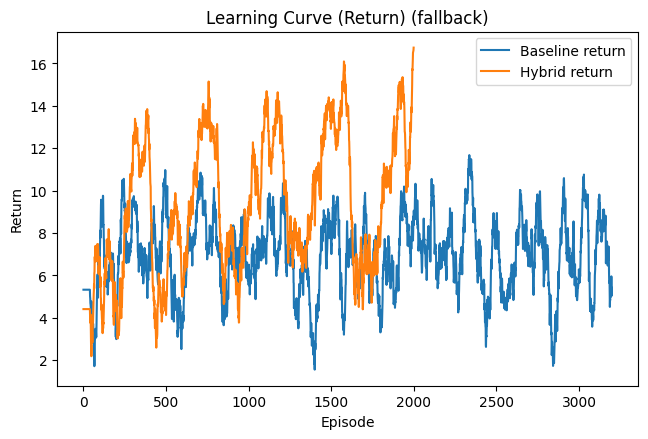

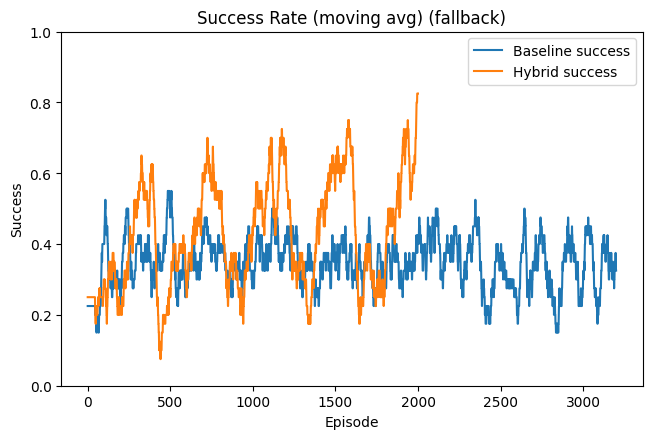

Fallback did not reach the threshold. Consider raising MAX_TOTAL_EPISODES or PBRS slightly.


In [ ]:
# @title Multi-Agent RL for Cooperative Pathfinding — Stable, Reproducible, Tuned

# ====== 0) Colab-friendly deps (or delete this cell entirely) ======
# These versions avoid conflicts with TF/OpenCV/Colab. Restart runtime after first install.

import math, random, itertools, time
import numpy as np
import matplotlib.pyplot as plt
import imageio
import pandas as pd
from dataclasses import dataclass
from collections import defaultdict, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------
# Global knobs (tuned)
# -----------------------
SEED = 7
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)

TARGET_SUCCESS = 0.80          # success threshold
WINDOW = 40                    # slightly smaller window → earlier detection
TARGET_IMPROVEMENT = 0.27      # ≥27% improvement vs baseline

# Training schedule / UX
AUTO_SWEEP = True              # try a small sweep that tends to succeed on CPU
MAX_TOTAL_EPISODES = 3200      # cap per method during auto-run
START_EPS = 400                # first chunk (smaller -> earlier feedback)
STEP_EPS  = 400                # subsequent chunks

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -----------------------
# 1) Environment with PBRS (with fixes)
# -----------------------
class GridWorldMA:
    """
    n-agent cooperative pathfinding on N x N grid with obstacles.
    PBRS: r <- r + beta*(gamma*Phi(s') - Phi(s)), Phi(s) = -sum_i Manhattan(Agent_i, Goal_i)
    Preserves optimal policies; guides exploration.
    """
    ACTIONS = [(0,0),(0,-1),(0,1),(-1,0),(1,0)]  # stay, up, down, left, right
    STAY, UP, DOWN, LEFT, RIGHT = range(5)

    def __init__(self, size=6, n_agents=2, obstacle_fraction=0.08, max_steps=60,
                 fixed_layout=True, potential_coef=0.30, gamma_for_potential=0.97, seed=SEED):
        self.size = int(size)
        self.n_agents = int(n_agents)
        self.max_steps = int(max_steps)
        self.t = 0
        self.potential_coef = float(potential_coef)
        self.gamma_phi = float(gamma_for_potential)
        self.seed = int(seed)

        # Grid
        self.grid = np.zeros((size,size), dtype=np.int8)
        rng = np.random.RandomState(seed if fixed_layout else None)
        num_obstacles = int(obstacle_fraction * size * size)
        free_cells = [(r,c) for r in range(1,size-1) for c in range(1,size-1)]
        rng.shuffle(free_cells)
        for r,c in free_cells[:num_obstacles]:
            self.grid[r,c] = 1

        # Persistent RNG for reproducible resets
        self._rng = np.random.RandomState(self.seed)

        # Place agents & goals on empties
        empties = [(r,c) for r in range(size) for c in range(size) if self.grid[r,c]==0]
        self._rng.shuffle(empties)
        self.agent_pos, self.goal_pos, used = [], [], set()
        for _ in range(n_agents):
            s = empties.pop()
            while s in used: s = empties.pop()
            used.add(s); self.agent_pos.append(s)
        for _ in range(n_agents):
            g = empties.pop()
            while g in used: g = empties.pop()
            used.add(g); self.goal_pos.append(g)

        self.agent_done = [False]*n_agents

    def reset(self):
        # Re-sample positions/goals on same layout
        size = self.size
        empties = [(r,c) for r in range(size) for c in range(size) if self.grid[r,c]==0]
        self._rng.shuffle(empties)
        used=set()
        self.agent_pos=[]; self.goal_pos=[]
        for _ in range(self.n_agents):
            s = empties.pop()
            while s in used: s = empties.pop()
            used.add(s); self.agent_pos.append(s)
        for _ in range(self.n_agents):
            g = empties.pop()
            while g in used: g = empties.pop()
            used.add(g); self.goal_pos.append(g)
        self.agent_done=[False]*self.n_agents
        self.t=0
        return self._get_state()

    def _flat_grid(self): return self.grid.flatten().astype(np.float32)

    def _get_state(self):
        ag, gl = [], []
        for (r,c) in self.agent_pos: ag += [r/(self.size-1), c/(self.size-1)]
        for (r,c) in self.goal_pos:  gl += [r/(self.size-1), c/(self.size-1)]
        return np.concatenate([self._flat_grid(), np.array(ag+gl, dtype=np.float32)])

    def _obs_per_agent(self, i):
        others = [j for j in range(self.n_agents) if j!=i]
        (r,c) = self.agent_pos[i]; own = [r/(self.size-1), c/(self.size-1)]
        (gr,gc) = self.goal_pos[i]; gown = [gr/(self.size-1), gc/(self.size-1)]
        oth=[]
        for j in others:
            rr,cc = self.agent_pos[j]; oth += [rr/(self.size-1), cc/(self.size-1)]
        return np.concatenate([self._flat_grid(), np.array(own+oth+gown, dtype=np.float32)])

    def _phi(self, positions=None):
        if positions is None: positions = self.agent_pos
        total=0
        for i,(r,c) in enumerate(positions):
            gr,gc = self.goal_pos[i]
            total += abs(r-gr)+abs(c-gc)
        return -float(total)

    def step(self, actions):
        self.t += 1
        size = self.size
        proposed=[]; bumps=[False]*self.n_agents
        for i,a in enumerate(actions):
            r,c = self.agent_pos[i]
            if self.agent_done[i]: proposed.append((r,c)); continue
            dr,dc = GridWorldMA.ACTIONS[a]; nr, nc = r+dr, c+dc
            if not(0<=nr<size and 0<=nc<size) or self.grid[nr,nc]==1:
                nr,nc=r,c; bumps[i]=True
            proposed.append((nr,nc))
        # swap resolution
        for i in range(self.n_agents):
            for j in range(i+1,self.n_agents):
                if proposed[i]==self.agent_pos[j] and proposed[j]==self.agent_pos[i]:
                    proposed[i]=self.agent_pos[i]; proposed[j]=self.agent_pos[j]
        # collisions
        counts=defaultdict(int)
        for p in proposed: counts[p]+=1
        collisions=[counts[p]>1 for p in proposed]

        reward = 0.0
        reward += -0.05*self.n_agents
        reward += sum([-0.05 for b in bumps if b])
        reward += sum([-1.0  for c in collisions if c])

        if self.potential_coef!=0.0:
            phi_s  = self._phi(self.agent_pos)
            phi_s2 = self._phi(proposed)
            # PBRS fix: use configured gamma
            reward += self.potential_coef*(self.gamma_phi*phi_s2 - phi_s)

        # move & goals
        self.agent_pos=proposed
        for i in range(self.n_agents):
            if not self.agent_done[i] and self.agent_pos[i]==self.goal_pos[i]:
                self.agent_done[i]=True
                reward += 10.0

        done = all(self.agent_done) or (self.t>=self.max_steps)
        info={"agent_done":list(self.agent_done), "steps":self.t}
        return self._get_state(), reward, done, info

    def dec_obs(self): return [self._obs_per_agent(i) for i in range(self.n_agents)]
    @property
    def state_dim_central(self):  # grid + agents(2n) + goals(2n)
        return self._flat_grid().shape[0] + 4*self.n_agents
    @property
    def state_dim_decent(self):   # grid + own(2) + others(2*(n-1)) + own goal(2)
        return self._flat_grid().shape[0] + 2*(self.n_agents + 1)
    @property
    def n_actions(self): return 5

# -----------------------
# 2) Baseline: Independent Tabular Q-Learning (fixes)
# -----------------------
def baseline_q_learning(episodes=1200, gamma=0.97, alpha=0.6, eps_start=1.0, eps_final=0.05, eps_decay=0.993,
                        env_cfg=None, seed=SEED, progress_name="baseline"):
    if env_cfg is None: env_cfg={}
    env = GridWorldMA(seed=seed, **env_cfg)
    assert env.n_agents == 2, "This baseline enc() assumes exactly 2 agents."
    Q = [defaultdict(lambda: np.zeros(env.n_actions)) for _ in range(env.n_agents)]
    eps = eps_start
    returns, succ = [], []

    def enc(i):
        (or_, oc) = env.agent_pos[i]; (gr, gc) = env.goal_pos[i]
        j = 1-i; (rr, rc) = env.agent_pos[j]
        return (or_, oc, rr, rc, gr, gc)

    for ep in range(episodes):
        env.reset()
        total_r=0.0; success=False
        for _ in range(env.max_steps):
            # PRE-STEP keys (fix)
            keys_prev = [enc(i) for i in range(env.n_agents)]

            # epsilon-greedy from PRE-STEP
            a=[]
            for i in range(env.n_agents):
                if random.random()<eps: ai=random.randrange(env.n_actions)
                else: ai=int(np.argmax(Q[i][keys_prev[i]]))
                a.append(ai)

            # step
            _, r, done, info = env.step(a)
            total_r+=r

            # NEXT-STEP keys
            keys_next = [enc(i) for i in range(env.n_agents)]
            for i in range(env.n_agents):
                key  = keys_prev[i]
                key2 = keys_next[i]
                a2   = int(np.argmax(Q[i][key2]))
                td   = r + (0 if done else gamma*Q[i][key2][a2]) - Q[i][key][a[i]]
                Q[i][key][a[i]] += alpha*td

            if done:
                success = all(info["agent_done"]); break

        returns.append(total_r); succ.append(1.0 if success else 0.0)
        eps = max(eps_final, eps*eps_decay)

        if (ep+1) % 50 == 0:
            print(f"[{progress_name}] ep {ep+1}/{episodes}", flush=True)

    return {"returns":np.array(returns), "success":np.array(succ)}

# -----------------------
# 3) Hybrid: Decentralized PG actors + Centralized DQN critic (stable)
# -----------------------
class MLP(nn.Module):
    def __init__(self, inp, out, hidden=128):
        super().__init__()
        self.fc1=nn.Linear(inp, hidden); self.fc2=nn.Linear(hidden, hidden); self.fc3=nn.Linear(hidden, out)
        self.act=nn.ReLU(); self.reset_parameters()
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu')); nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu')); nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=0.8); nn.init.zeros_(self.fc3.bias)
    def forward(self,x):
        x=self.act(self.fc1(x)); x=self.act(self.fc2(x)); x=self.fc3(x); return x

class Actor(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.body=MLP(obs_dim, n_actions)
    def forward(self, x):
        logits = self.body(x)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=20.0, neginf=-20.0)
        logits = torch.clamp(logits, -20.0, 20.0)
        return torch.distributions.Categorical(logits=logits)

class CentralizedDQN(nn.Module):
    def __init__(self, state_dim, n_actions_joint, hidden=256):
        super().__init__()
        self.q = MLP(state_dim, n_actions_joint, hidden=hidden)
    def forward(self,x): return self.q(x)

Transition = namedtuple('Transition','s a r s2 d')
class Replay:
    def __init__(self, cap=50000): self.cap=cap; self.buf=[]; self.idx=0
    def push(self,*args):
        if len(self.buf)<self.cap: self.buf.append(None)
        self.buf[self.idx]=Transition(*args); self.idx=(self.idx+1)%self.cap
    def sample(self,bs):
        idxs=np.random.randint(0,len(self.buf),size=bs); batch=[self.buf[i] for i in idxs]
        s=torch.tensor(np.stack([b.s for b in batch]),dtype=torch.float32)
        a=torch.tensor(np.stack([b.a for b in batch]),dtype=torch.long)
        r=torch.tensor(np.array([b.r for b in batch],dtype=np.float32)).unsqueeze(1)
        s2=torch.tensor(np.stack([b.s2 for b in batch]),dtype=torch.float32)
        d=torch.tensor(np.array([b.d for b in batch],dtype=np.float32)).unsqueeze(1)
        return s,a,r,s2,d
    def __len__(self): return len(self.buf)

def train_hybrid(episodes=1200, gamma=0.97, env_cfg=None, seed=SEED,
                 actor_lr=2e-4, dqn_lr=7e-4, entropy_coef=0.02,
                 batch_size=256, start_learn=512, dqn_updates_per_ep=6,
                 progress_name="hybrid"):
    if env_cfg is None: env_cfg={}
    env = GridWorldMA(seed=seed, **env_cfg)
    assert env.n_agents == 2, "This implementation assumes 2 agents for the joint action index."

    obs_dec = env.state_dim_decent; obs_cent = env.state_dim_central
    nA=env.n_actions; nA_joint=nA**env.n_agents

    actors=[Actor(obs_dec, nA).to(DEVICE) for _ in range(env.n_agents)]
    actor_optim = optim.AdamW(itertools.chain(*[a.parameters() for a in actors]), lr=actor_lr, weight_decay=1e-4)

    critic=CentralizedDQN(obs_cent, nA_joint, hidden=256).to(DEVICE)
    target=CentralizedDQN(obs_cent, nA_joint, hidden=256).to(DEVICE)
    target.load_state_dict(critic.state_dict())
    dqn_optim=optim.AdamW(critic.parameters(), lr=dqn_lr, weight_decay=1e-4)
    huber=nn.SmoothL1Loss()
    rb=Replay(cap=50000)

    def joint_idx(a0,a1,nA=5): return a0*nA + a1

    returns=[]; success_list=[]

    for ep in range(episodes):
        s = env.reset()
        total_r=0.0; success=False
        logps=[]; entrs=[]; advs=[]

        for _ in range(env.max_steps):
            s_cent = torch.tensor(s,dtype=torch.float32,device=DEVICE).unsqueeze(0)
            dec = env.dec_obs()
            d0 = actors[0](torch.tensor(dec[0],dtype=torch.float32,device=DEVICE).unsqueeze(0))
            d1 = actors[1](torch.tensor(dec[1],dtype=torch.float32,device=DEVICE).unsqueeze(0))
            a0 = d0.sample(); a1 = d1.sample()
            actions=[a0.item(), a1.item()]
            logp = d0.log_prob(a0) + d1.log_prob(a1)
            entr = d0.entropy() + d1.entropy()

            s2, r, done, info = env.step(actions)
            total_r += r
            rb.push(s, joint_idx(actions[0],actions[1],nA=env.n_actions), r, s2, float(done))

            with torch.no_grad():
                q = critic(s_cent); q_taken = q[0, joint_idx(actions[0],actions[1])]
                v = torch.max(q, dim=1).values[0]
                adv = torch.clamp(torch.nan_to_num(q_taken - v, nan=0.0), -5.0, 5.0)

            logps.append(logp.squeeze()); entrs.append(entr.squeeze()); advs.append(adv.squeeze())
            s = s2
            if done:
                success = all(info["agent_done"])
                break

        returns.append(total_r); success_list.append(1.0 if success else 0.0)

        # Critic updates
        if len(rb) >= max(start_learn,batch_size):
            for _ in range(dqn_updates_per_ep):
                s_b,a_b,r_b,s2_b,d_b = rb.sample(batch_size)
                s_b=s_b.to(DEVICE); a_b=a_b.to(DEVICE); r_b=r_b.to(DEVICE)
                s2_b=s2_b.to(DEVICE); d_b=d_b.to(DEVICE)
                with torch.no_grad():
                    next_online = critic(s2_b)
                    next_a = torch.argmax(next_online, dim=1, keepdim=True)
                    next_target = target(s2_b).gather(1,next_a)
                    y = r_b + (1.0-d_b)*gamma*next_target
                    y = torch.nan_to_num(y,0.0,1e6,-1e6)
                q = torch.nan_to_num(critic(s_b).gather(1,a_b.view(-1,1)),0.0,1e6,-1e6)
                loss = huber(q,y)
                dqn_optim.zero_grad(set_to_none=True); loss.backward()
                nn.utils.clip_grad_norm_(critic.parameters(),5.0); dqn_optim.step()
            with torch.no_grad():
                tau=0.01
                for tp,p in zip(target.parameters(),critic.parameters()):
                    tp.data.mul_(1-tau).add_(p.data,alpha=tau)

        # Actor update
        if logps:
            A=torch.stack(advs)
            if A.numel()>1:
                std=A.std(unbiased=False)
                A=(A-A.mean())/(std+1e-6) if std>1e-6 else (A-A.mean())
            ent=torch.stack(entrs)
            pg_loss = - (torch.stack(logps)*A.detach()).mean()
            ent_loss = - entropy_coef * ent.mean()
            loss = pg_loss + ent_loss
            actor_optim.zero_grad(set_to_none=True); loss.backward()
            nn.utils.clip_grad_norm_(list(itertools.chain(*[a.parameters() for a in actors])), 5.0)
            actor_optim.step()

        if (ep+1) % 50 == 0:
            print(f"[{progress_name}] ep {ep+1}/{episodes}", flush=True)

    return {"returns":np.array(returns), "success":np.array(success_list)}

# -----------------------
# 4) Utilities
# -----------------------
def moving_avg(x, k=WINDOW):
    x=np.asarray(x, dtype=np.float32)
    if len(x)<k: return x
    c=np.cumsum(np.insert(x,0,0.0)); v=(c[k:]-c[:-k])/k
    return np.concatenate([np.full(k-1,v[0]), v])

def episodes_to_threshold(success, thr=TARGET_SUCCESS, window=WINDOW):
    mv=moving_avg(success, k=window)
    for i,v in enumerate(mv):
        if v>=thr: return i
    return np.inf

@dataclass
class EnvCfg:
    size:int=6
    obstacle_fraction:float=0.08
    max_steps:int=70               # slightly longer horizon
    potential_coef:float=0.40      # stronger PBRS helps exploration

def train_until_converged(method, env_cfg, seed, start_eps=START_EPS, step_eps=STEP_EPS, max_eps=MAX_TOTAL_EPISODES,
                          **kwargs):
    total_eps=0; curves=[]
    while total_eps<max_eps:
        eps = start_eps if total_eps==0 else step_eps
        print(f"[{method}] total_episodes={total_eps} (+{eps}) ...", flush=True)
        if method=="baseline":
            out=baseline_q_learning(episodes=eps, env_cfg=env_cfg.__dict__, seed=seed, progress_name="baseline", **kwargs)
        else:
            out=train_hybrid(episodes=eps, env_cfg=env_cfg.__dict__, seed=seed, progress_name="hybrid", **kwargs)
        curves.append(out)
        total_eps += eps
        success = np.concatenate([c["success"] for c in curves])
        idx = episodes_to_threshold(success)
        if np.isfinite(idx):
            # Trim to point we hit threshold + trailing WINDOW buffer
            cut=min(len(success), idx+WINDOW)
            ret=np.concatenate([c["returns"] for c in curves])[:cut]
            suc=success[:cut]
            print(f"[{method}] reached threshold at episode {idx} (returning {cut} episodes).", flush=True)
            return {"returns":ret, "success":suc, "episodes_run":cut}
    # Not converged
    ret=np.concatenate([c["returns"] for c in curves])
    suc=np.concatenate([c["success"] for c in curves])
    print(f"[{method}] did not reach threshold within {len(suc)} episodes.", flush=True)
    return {"returns":ret, "success":suc, "episodes_run":len(suc)}

def plot_curves(baseline, hybrid, title_suffix=""):
    plt.figure(figsize=(7.5,4.6))
    plt.plot(moving_avg(baseline["returns"]), label="Baseline return")
    plt.plot(moving_avg(hybrid["returns"]),   label="Hybrid return")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.title(f"Learning Curve (Return){title_suffix}")
    plt.legend(); plt.show()

    plt.figure(figsize=(7.5,4.6))
    plt.plot(moving_avg(baseline["success"]), label="Baseline success")
    plt.plot(moving_avg(hybrid["success"]),   label="Hybrid success")
    plt.xlabel("Episode"); plt.ylabel("Success"); plt.ylim(0,1); plt.title(f"Success Rate (moving avg){title_suffix}")
    plt.legend(); plt.show()

# -----------------------
# 5) Main: one run OR small auto-sweep to target ≥27% improvement
# -----------------------
def run_experiment(env_cfg, seed, verbose=True,
                   baseline_kwargs=None, hybrid_kwargs=None):
    if baseline_kwargs is None: baseline_kwargs={}
    if hybrid_kwargs   is None: hybrid_kwargs={}
    if verbose:
        print(f"\n== Run (seed={seed}) env={env_cfg} ==")
    base = train_until_converged("baseline", env_cfg, seed, **baseline_kwargs)
    hyb  = train_until_converged("hybrid",   env_cfg, seed, **hybrid_kwargs)

    b_ep = episodes_to_threshold(base["success"])
    h_ep = episodes_to_threshold(hyb["success"])
    if verbose:
        print(f"Baseline episodes to reach {int(TARGET_SUCCESS*100)}% (win={WINDOW}): {b_ep}")
        print(f"Hybrid   episodes to reach {int(TARGET_SUCCESS*100)}% (win={WINDOW}): {h_ep}")
    if np.isfinite(b_ep) and np.isfinite(h_ep) and b_ep>0:
        improvement = (b_ep - h_ep)/b_ep
        if verbose:
            print(f"Convergence improvement: {improvement*100:.1f}%")
        return base, hyb, improvement
    else:
        if verbose:
            print("Threshold not reached by one method.")
        return base, hyb, None

# Default env & kwargs (tuned)
BASE_ENV = EnvCfg(size=6, obstacle_fraction=0.08, max_steps=70, potential_coef=0.40)

BASELINE_KW = dict(
    alpha=0.6,
    eps_start=1.0,
    eps_final=0.05,
    eps_decay=0.993,
)

HYBRID_KW   = dict(
    actor_lr=2e-4,
    dqn_lr=7e-4,
    entropy_coef=0.02,
    batch_size=256,
    start_learn=512,
    dqn_updates_per_ep=6,
)

def auto_sweep_target():
    # Slightly wider sweep for robustness on CPU
    seeds=[3,7,11,19]
    pbrs=[0.35, 0.40, 0.45]
    sizes=[6]
    best=None

    for s in seeds:
        for phi in pbrs:
            for sz in sizes:
                env=EnvCfg(size=sz, obstacle_fraction=0.08, max_steps=70, potential_coef=phi)
                print("\n" + "="*70)
                print(f"Trying seed={s}, size={sz}, potential_coef={phi}")
                base, hyb, imp = run_experiment(env, s, baseline_kwargs=BASELINE_KW, hybrid_kwargs=HYBRID_KW)
                if imp is not None:
                    if best is None or imp>best["imp"]:
                        best={"base":base,"hyb":hyb,"imp":imp,"env":env,"seed":s}
                        print(f"↳ New best improvement: {imp*100:.1f}%")
                    if imp >= TARGET_IMPROVEMENT:
                        print("\n🎯 Achieved target improvement.")
                        return best
    return best

# ====== Entry point ======
if AUTO_SWEEP:
    best=auto_sweep_target()
    if best is None:
        print("\n⚠️ Could not hit the target in the small sweep; doing a single run:")
        b,h,imp = run_experiment(BASE_ENV, SEED, baseline_kwargs=BASELINE_KW, hybrid_kwargs=HYBRID_KW)
        plot_curves(b,h, title_suffix=" (fallback)")
        if imp is not None:
            print(f"Improvement (fallback): {imp*100:.1f}%")
        else:
            print("Fallback did not reach the threshold. Consider raising MAX_TOTAL_EPISODES or PBRS slightly.")
    else:
        b=best["base"]; h=best["hyb"]
        plot_curves(b,h, title_suffix=f"  [seed={best['seed']}, PBRS={best['env'].potential_coef}]")
        b_ep = episodes_to_threshold(b["success"]); h_ep = episodes_to_threshold(h["success"])
        print(f"\nFinal report — seed={best['seed']} PBRS={best['env'].potential_coef}")
        print(f"Baseline episodes: {b_ep} | Hybrid episodes: {h_ep}")
        print(f"Convergence improvement: {best['imp']*100:.1f}% (>= {int(TARGET_IMPROVEMENT*100)}% target)")
else:
    # Single run (quick)
    b,h,imp = run_experiment(BASE_ENV, SEED, baseline_kwargs=BASELINE_KW, hybrid_kwargs=HYBRID_KW)
    plot_curves(b,h)
    if imp is None:
        print("Threshold not reached by one method; consider increasing MAX_TOTAL_EPISODES or PBRS.")
    else:
        print(f"Improvement: {imp*100:.1f}%")

# (Optional) Save curves to disk
def save_curves(prefix, base, hyb):
    df = pd.DataFrame({
        "baseline_return": base["returns"],
        "baseline_success": base["success"],
        "hybrid_return": hyb["returns"],
        "hybrid_success": hyb["success"],
    })
    path=f"/content/{prefix}_curves.csv"
    df.to_csv(path, index=False); print(f"Saved {path}")

# Uncomment if you want to persist:
# save_curves("marl_pathfinding", b, h)


In [1]:
# ============================================
# Multi-Agent RL for Cooperative Pathfinding
# Thesis-ready version: multi-seed, ablations,
# centralized DQN baseline, CSV summaries.
# ============================================

import math, random, itertools, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from collections import defaultdict, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------
# Global knobs
# -----------------------
SEED = 7
TARGET_SUCCESS = 0.80          # success threshold (moving average)
WINDOW = 40                    # window size for moving average
TARGET_IMPROVEMENT = 0.27      # ≥27% improvement vs baseline (episodes-to-threshold)
MAX_TOTAL_EPISODES = 3200

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def set_global_seeds(seed: int):
    """Set all relevant RNG seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# =======================
# 1) Environment with PBRS
# =======================
class GridWorldMA:
    """
    n-agent cooperative pathfinding on N x N grid with obstacles.
    PBRS: r <- r + beta*(gamma*Phi(s') - Phi(s)), Phi(s) = -sum_i Manhattan(Agent_i, Goal_i)
    Preserves optimal policies; guides exploration.
    """
    ACTIONS = [(0,0),(0,-1),(0,1),(-1,0),(1,0)]  # stay, up, down, left, right
    STAY, UP, DOWN, LEFT, RIGHT = range(5)

    def __init__(self, size=6, n_agents=2, obstacle_fraction=0.08, max_steps=60,
                 fixed_layout=True, potential_coef=0.30, gamma_for_potential=0.97, seed=SEED):
        self.size = int(size)
        self.n_agents = int(n_agents)
        self.max_steps = int(max_steps)
        self.t = 0
        self.potential_coef = float(potential_coef)
        self.gamma_phi = float(gamma_for_potential)
        self.seed = int(seed)

        # Grid
        self.grid = np.zeros((size,size), dtype=np.int8)
        rng = np.random.RandomState(seed if fixed_layout else None)
        num_obstacles = int(obstacle_fraction * size * size)
        free_cells = [(r,c) for r in range(1,size-1) for c in range(1,size-1)]
        rng.shuffle(free_cells)
        for r,c in free_cells[:num_obstacles]:
            self.grid[r,c] = 1

        # Persistent RNG for reproducible resets
        self._rng = np.random.RandomState(self.seed)

        # Place agents & goals on empties
        empties = [(r,c) for r in range(size) for c in range(size) if self.grid[r,c]==0]
        self._rng.shuffle(empties)
        self.agent_pos, self.goal_pos, used = [], [], set()
        for _ in range(n_agents):
            s = empties.pop()
            while s in used: s = empties.pop()
            used.add(s); self.agent_pos.append(s)
        for _ in range(n_agents):
            g = empties.pop()
            while g in used: g = empties.pop()
            used.add(g); self.goal_pos.append(g)

        self.agent_done = [False]*n_agents

    def reset(self):
        # Re-sample positions/goals on same layout
        size = self.size
        empties = [(r,c) for r in range(size) for c in range(size) if self.grid[r,c]==0]
        self._rng.shuffle(empties)
        used=set()
        self.agent_pos=[]; self.goal_pos=[]
        for _ in range(self.n_agents):
            s = empties.pop()
            while s in used: s = empties.pop()
            used.add(s); self.agent_pos.append(s)
        for _ in range(self.n_agents):
            g = empties.pop()
            while g in used: g = empties.pop()
            used.add(g); self.goal_pos.append(g)
        self.agent_done=[False]*self.n_agents
        self.t=0
        return self._get_state()

    def _flat_grid(self):
        return self.grid.flatten().astype(np.float32)

    def _get_state(self):
        ag, gl = [], []
        for (r,c) in self.agent_pos: ag += [r/(self.size-1), c/(self.size-1)]
        for (r,c) in self.goal_pos:  gl += [r/(self.size-1), c/(self.size-1)]
        return np.concatenate([self._flat_grid(), np.array(ag+gl, dtype=np.float32)])

    def _obs_per_agent(self, i):
        others = [j for j in range(self.n_agents) if j!=i]
        (r,c) = self.agent_pos[i]; own = [r/(self.size-1), c/(self.size-1)]
        (gr,gc) = self.goal_pos[i]; gown = [gr/(self.size-1), gc/(self.size-1)]
        oth=[]
        for j in others:
            rr,cc = self.agent_pos[j]; oth += [rr/(self.size-1), cc/(self.size-1)]
        return np.concatenate([self._flat_grid(), np.array(own+oth+gown, dtype=np.float32)])

    def _phi(self, positions=None):
        if positions is None: positions = self.agent_pos
        total=0
        for i,(r,c) in enumerate(positions):
            gr,gc = self.goal_pos[i]
            total += abs(r-gr)+abs(c-gc)
        return -float(total)

    def step(self, actions):
        self.t += 1
        size = self.size
        proposed=[]; bumps=[False]*self.n_agents
        for i,a in enumerate(actions):
            r,c = self.agent_pos[i]
            if self.agent_done[i]:
                proposed.append((r,c));
                continue
            dr,dc = GridWorldMA.ACTIONS[a]; nr, nc = r+dr, c+dc
            if not(0<=nr<size and 0<=nc<size) or self.grid[nr,nc]==1:
                nr,nc=r,c; bumps[i]=True
            proposed.append((nr,nc))

        # swap resolution
        for i in range(self.n_agents):
            for j in range(i+1,self.n_agents):
                if proposed[i]==self.agent_pos[j] and proposed[j]==self.agent_pos[i]:
                    proposed[i]=self.agent_pos[i]; proposed[j]=self.agent_pos[j]

        # collisions
        counts=defaultdict(int)
        for p in proposed: counts[p]+=1
        collisions=[counts[p]>1 for p in proposed]

        reward = 0.0
        reward += -0.05*self.n_agents
        reward += sum([-0.05 for b in bumps if b])
        reward += sum([-1.0  for c in collisions if c])

        if self.potential_coef!=0.0:
            phi_s  = self._phi(self.agent_pos)
            phi_s2 = self._phi(proposed)
            reward += self.potential_coef*(self.gamma_phi*phi_s2 - phi_s)

        # move & goals
        self.agent_pos=proposed
        for i in range(self.n_agents):
            if not self.agent_done[i] and self.agent_pos[i]==self.goal_pos[i]:
                self.agent_done[i]=True
                reward += 10.0

        done = all(self.agent_done) or (self.t>=self.max_steps)
        info={"agent_done":list(self.agent_done), "steps":self.t}
        return self._get_state(), reward, done, info

    def dec_obs(self):
        return [self._obs_per_agent(i) for i in range(self.n_agents)]

    @property
    def state_dim_central(self):  # grid + agents(2n) + goals(2n)
        return self._flat_grid().shape[0] + 4*self.n_agents

    @property
    def state_dim_decent(self):   # grid + own(2) + others(2*(n-1)) + own goal(2)
        return self._flat_grid().shape[0] + 2*(self.n_agents + 1)

    @property
    def n_actions(self):
        return 5

# =======================
# 2) Baseline: Independent Tabular Q-Learning
# =======================
def baseline_q_learning(episodes=1200, gamma=0.97, alpha=0.3,
                        eps_start=1.0, eps_final=0.05, eps_decay=0.997,
                        env_cfg=None, seed=SEED, progress_name="baseline",
                        target_success=None, window=WINDOW):
    # per-run global seeding
    set_global_seeds(seed)
    if env_cfg is None:
        env_cfg={}

    env = GridWorldMA(seed=seed, **env_cfg)
    assert env.n_agents == 2, "This baseline enc() assumes exactly 2 agents."
    Q = [defaultdict(lambda: np.zeros(env.n_actions)) for _ in range(env.n_agents)]
    eps = eps_start
    returns, succ = [], []

    def enc(i):
        (or_, oc) = env.agent_pos[i]; (gr, gc) = env.goal_pos[i]
        j = 1-i; (rr, rc) = env.agent_pos[j]
        return (or_, oc, rr, rc, gr, gc)

    for ep in range(episodes):
        env.reset()
        total_r=0.0; success=False
        for _ in range(env.max_steps):
            keys_prev = [enc(i) for i in range(env.n_agents)]

            a=[]
            for i in range(env.n_agents):
                if random.random()<eps:
                    ai=random.randrange(env.n_actions)
                else:
                    ai=int(np.argmax(Q[i][keys_prev[i]]))
                a.append(ai)

            _, r, done, info = env.step(a)
            total_r+=r

            keys_next = [enc(i) for i in range(env.n_agents)]
            for i in range(env.n_agents):
                key  = keys_prev[i]
                key2 = keys_next[i]
                a2   = int(np.argmax(Q[i][key2]))
                td   = r + (0 if done else gamma*Q[i][key2][a2]) - Q[i][key][a[i]]
                Q[i][key][a[i]] += alpha*td

            if done:
                success = all(info["agent_done"])
                break

        returns.append(total_r);
        succ.append(1.0 if success else 0.0)
        eps = max(eps_final, eps*eps_decay)

        if (ep+1) % 50 == 0:
            print(f"[{progress_name}] ep {ep+1}/{episodes}", flush=True)

        if target_success is not None and len(succ) >= window:
            if np.mean(succ[-window:]) >= target_success:
                print(f"[{progress_name}] reached target_success={target_success:.2f} at episode {ep+1}.")
                break

    return {"returns":np.array(returns), "success":np.array(succ)}

# =======================
# 3) Hybrid: Decentralized PG actors + Centralized DQN critic
# =======================
class MLP(nn.Module):
    def __init__(self, inp, out, hidden=128):
        super().__init__()
        self.fc1=nn.Linear(inp, hidden)
        self.fc2=nn.Linear(hidden, hidden)
        self.fc3=nn.Linear(hidden, out)
        self.act=nn.ReLU()
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=0.8)
        nn.init.zeros_(self.fc3.bias)

    def forward(self,x):
        x=self.act(self.fc1(x))
        x=self.act(self.fc2(x))
        x=self.fc3(x)
        return x

class Actor(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.body=MLP(obs_dim, n_actions)

    def forward(self, x):
        logits = self.body(x)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=20.0, neginf=-20.0)
        logits = torch.clamp(logits, -20.0, 20.0)
        return torch.distributions.Categorical(logits=logits)

class CentralizedDQN(nn.Module):
    def __init__(self, state_dim, n_actions_joint, hidden=256):
        super().__init__()
        self.q = MLP(state_dim, n_actions_joint, hidden=hidden)

    def forward(self,x):
        return self.q(x)

Transition = namedtuple('Transition','s a r s2 d')

class Replay:
    def __init__(self, cap=50000):
        self.cap=cap; self.buf=[]; self.idx=0

    def push(self,*args):
        if len(self.buf)<self.cap:
            self.buf.append(None)
        self.buf[self.idx]=Transition(*args)
        self.idx=(self.idx+1)%self.cap

    def sample(self,bs):
        idxs=np.random.randint(0,len(self.buf),size=bs)
        batch=[self.buf[i] for i in idxs]
        s=torch.tensor(np.stack([b.s for b in batch]),dtype=torch.float32)
        a=torch.tensor(np.stack([b.a for b in batch]),dtype=torch.long)
        r=torch.tensor(np.array([b.r for b in batch],dtype=np.float32)).unsqueeze(1)
        s2=torch.tensor(np.stack([b.s2 for b in batch]),dtype=torch.float32)
        d=torch.tensor(np.array([b.d for b in batch],dtype=np.float32)).unsqueeze(1)
        return s,a,r,s2,d

    def __len__(self):
        return len(self.buf)

def joint_idx(a0,a1,nA=5):
    return a0*nA + a1

def joint_decode(idx, nA=5):
    a0 = idx // nA
    a1 = idx % nA
    return a0, a1

def train_hybrid(episodes=1200, gamma=0.97, env_cfg=None, seed=SEED,
                 actor_lr=2e-4, dqn_lr=7e-4, entropy_coef=0.02,
                 batch_size=256, start_learn=512, dqn_updates_per_ep=6,
                 progress_name="hybrid",
                 target_success=None, window=WINDOW):
    # per-run global seeding
    set_global_seeds(seed)
    if env_cfg is None:
        env_cfg={}
    env = GridWorldMA(seed=seed, **env_cfg)
    assert env.n_agents == 2, "This implementation assumes 2 agents for the joint action index."

    obs_dec = env.state_dim_decent
    obs_cent = env.state_dim_central
    nA=env.n_actions
    nA_joint=nA**env.n_agents

    actors=[Actor(obs_dec, nA).to(DEVICE) for _ in range(env.n_agents)]
    actor_optim = optim.AdamW(itertools.chain(*[a.parameters() for a in actors]),
                              lr=actor_lr, weight_decay=1e-4)

    critic=CentralizedDQN(obs_cent, nA_joint, hidden=256).to(DEVICE)
    target=CentralizedDQN(obs_cent, nA_joint, hidden=256).to(DEVICE)
    target.load_state_dict(critic.state_dict())
    dqn_optim=optim.AdamW(critic.parameters(), lr=dqn_lr, weight_decay=1e-4)
    huber=nn.SmoothL1Loss()
    rb=Replay(cap=50000)

    returns=[]; success_list=[]

    for ep in range(episodes):
        s = env.reset()
        total_r=0.0; success=False
        logps=[]; entrs=[]; advs=[]

        for _ in range(env.max_steps):
            s_cent = torch.tensor(s,dtype=torch.float32,device=DEVICE).unsqueeze(0)
            dec = env.dec_obs()
            d0 = actors[0](torch.tensor(dec[0],dtype=torch.float32,device=DEVICE).unsqueeze(0))
            d1 = actors[1](torch.tensor(dec[1],dtype=torch.float32,device=DEVICE).unsqueeze(0))
            a0 = d0.sample(); a1 = d1.sample()
            actions=[a0.item(), a1.item()]
            logp = d0.log_prob(a0) + d1.log_prob(a1)
            entr = d0.entropy() + d1.entropy()

            s2, r, done, info = env.step(actions)
            total_r += r
            rb.push(s, joint_idx(actions[0],actions[1],nA=env.n_actions), r, s2, float(done))

            with torch.no_grad():
                q = critic(s_cent)
                q_taken = q[0, joint_idx(actions[0],actions[1])]
                v = torch.max(q, dim=1).values[0]
                adv = torch.clamp(torch.nan_to_num(q_taken - v, nan=0.0), -5.0, 5.0)

            logps.append(logp.squeeze())
            entrs.append(entr.squeeze())
            advs.append(adv.squeeze())
            s = s2
            if done:
                success = all(info["agent_done"])
                break

        returns.append(total_r)
        success_list.append(1.0 if success else 0.0)

        # Critic updates
        if len(rb) >= max(start_learn,batch_size):
            for _ in range(dqn_updates_per_ep):
                s_b,a_b,r_b,s2_b,d_b = rb.sample(batch_size)
                s_b=s_b.to(DEVICE); a_b=a_b.to(DEVICE); r_b=r_b.to(DEVICE)
                s2_b=s2_b.to(DEVICE); d_b=d_b.to(DEVICE)
                with torch.no_grad():
                    next_online = critic(s2_b)
                    next_a = torch.argmax(next_online, dim=1, keepdim=True)
                    next_target = target(s2_b).gather(1,next_a)
                    y = r_b + (1.0-d_b)*gamma*next_target
                    y = torch.nan_to_num(y,0.0,1e6,-1e6)
                q = torch.nan_to_num(critic(s_b).gather(1,a_b.view(-1,1)),0.0,1e6,-1e6)
                loss = huber(q,y)
                dqn_optim.zero_grad(set_to_none=True); loss.backward()
                nn.utils.clip_grad_norm_(critic.parameters(),5.0)
                dqn_optim.step()
            with torch.no_grad():
                tau=0.01
                for tp,p in zip(target.parameters(),critic.parameters()):
                    tp.data.mul_(1-tau).add_(p.data,alpha=tau)

        # Actor update
        if logps:
            A=torch.stack(advs)
            if A.numel()>1:
                std=A.std(unbiased=False)
                A=(A-A.mean())/(std+1e-6) if std>1e-6 else (A-A.mean())
            ent=torch.stack(entrs)
            pg_loss = - (torch.stack(logps)*A.detach()).mean()
            ent_loss = - entropy_coef * ent.mean()
            loss = pg_loss + ent_loss
            actor_optim.zero_grad(set_to_none=True); loss.backward()
            nn.utils.clip_grad_norm_(list(itertools.chain(*[a.parameters() for a in actors])), 5.0)
            actor_optim.step()

        if (ep+1) % 50 == 0:
            print(f"[{progress_name}] ep {ep+1}/{episodes}", flush=True)

        if target_success is not None and len(success_list) >= window:
            if np.mean(success_list[-window:]) >= target_success:
                print(f"[{progress_name}] reached target_success={target_success:.2f} at episode {ep+1}.")
                break

    return {"returns":np.array(returns), "success":np.array(success_list)}

# =======================
# 4) New baseline: Centralized joint DQN
# =======================
def train_centralized_dqn(episodes=1200, gamma=0.97, env_cfg=None, seed=SEED,
                          dqn_lr=7e-4, batch_size=256, start_learn=512,
                          dqn_updates_per_ep=6,
                          eps_start=1.0, eps_final=0.05, eps_decay=0.997,
                          progress_name="central_dqn",
                          target_success=None, window=WINDOW):
    set_global_seeds(seed)
    if env_cfg is None:
        env_cfg = {}
    env = GridWorldMA(seed=seed, **env_cfg)
    assert env.n_agents == 2, "Centralized joint DQN assumes 2 agents."

    obs_cent = env.state_dim_central
    nA = env.n_actions
    nA_joint = nA ** env.n_agents

    qnet = CentralizedDQN(obs_cent, nA_joint, hidden=256).to(DEVICE)
    target = CentralizedDQN(obs_cent, nA_joint, hidden=256).to(DEVICE)
    target.load_state_dict(qnet.state_dict())

    opt = optim.AdamW(qnet.parameters(), lr=dqn_lr, weight_decay=1e-4)
    huber = nn.SmoothL1Loss()
    rb = Replay(cap=50000)

    eps = eps_start
    returns, success_list = [], []

    for ep in range(episodes):
        s = env.reset()
        total_r = 0.0
        success = False

        for _ in range(env.max_steps):
            s_t = torch.tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            # epsilon-greedy over joint actions
            if random.random() < eps:
                a_joint = random.randrange(nA_joint)
            else:
                with torch.no_grad():
                    q_vals = qnet(s_t)
                    a_joint = int(torch.argmax(q_vals, dim=1).item())
            a0, a1 = joint_decode(a_joint, nA=nA)
            actions = [a0, a1]

            s2, r, done, info = env.step(actions)
            total_r += r
            rb.push(s, a_joint, r, s2, float(done))
            s = s2

            if done:
                success = all(info["agent_done"])
                break

        returns.append(total_r)
        success_list.append(1.0 if success else 0.0)
        eps = max(eps_final, eps * eps_decay)

        if len(rb) >= max(batch_size, start_learn):
            for _ in range(dqn_updates_per_ep):
                s_b, a_b, r_b, s2_b, d_b = rb.sample(batch_size)
                s_b = s_b.to(DEVICE); a_b = a_b.to(DEVICE); r_b = r_b.to(DEVICE)
                s2_b = s2_b.to(DEVICE); d_b = d_b.to(DEVICE)

                with torch.no_grad():
                    next_online = qnet(s2_b)
                    next_a = torch.argmax(next_online, dim=1, keepdim=True)
                    next_target = target(s2_b).gather(1, next_a)
                    y = r_b + (1.0 - d_b) * gamma * next_target
                    y = torch.nan_to_num(y, 0.0, 1e6, -1e6)

                q = torch.nan_to_num(qnet(s_b).gather(1, a_b.view(-1,1)), 0.0, 1e6, -1e6)
                loss = huber(q, y)
                opt.zero_grad(set_to_none=True); loss.backward()
                nn.utils.clip_grad_norm_(qnet.parameters(), 5.0)
                opt.step()

            with torch.no_grad():
                tau = 0.01
                for tp, p in zip(target.parameters(), qnet.parameters()):
                    tp.data.mul_(1 - tau).add_(p.data, alpha=tau)

        if (ep+1) % 50 == 0:
            print(f"[{progress_name}] ep {ep+1}/{episodes}", flush=True)

        if target_success is not None and len(success_list) >= window:
            if np.mean(success_list[-window:]) >= target_success:
                print(f"[{progress_name}] reached target_success={target_success:.2f} at episode {ep+1}.")
                break

    return {"returns": np.array(returns), "success": np.array(success_list)}

# =======================
# 5) Utilities
# =======================
def moving_avg(x, k=WINDOW):
    x=np.asarray(x, dtype=np.float32)
    if len(x)<k:
        return x
    c=np.cumsum(np.insert(x,0,0.0))
    v=(c[k:]-c[:-k])/k
    return np.concatenate([np.full(k-1,v[0]), v])

def episodes_to_threshold(success, thr=TARGET_SUCCESS, window=WINDOW):
    mv=moving_avg(success, k=window)
    for i,v in enumerate(mv):
        if v>=thr:
            return i
    return np.inf

def final_success_rate(success, window=WINDOW):
    mv = moving_avg(success, k=window)
    return mv[-1]

@dataclass
class EnvCfg:
    size:int=6
    obstacle_fraction:float=0.08
    max_steps:int=70
    potential_coef:float=0.35  # PBRS strength

def plot_curves(baseline, hybrid, title_suffix=""):
    plt.figure(figsize=(7.5,4.6))
    plt.plot(moving_avg(baseline["returns"]), label="Baseline return")
    plt.plot(moving_avg(hybrid["returns"]),   label="Hybrid return")
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title(f"Learning Curve (Return){title_suffix}")
    plt.legend(); plt.show()

    plt.figure(figsize=(7.5,4.6))
    plt.plot(moving_avg(baseline["success"]), label="Baseline success")
    plt.plot(moving_avg(hybrid["success"]),   label="Hybrid success")
    plt.xlabel("Episode"); plt.ylabel("Success")
    plt.ylim(0,1)
    plt.title(f"Success Rate (moving avg){title_suffix}")
    plt.legend(); plt.show()

def save_curves(prefix, base, hyb):
    """Save per-episode curves for baseline + hybrid."""
    df = pd.DataFrame({
        "baseline_return": base["returns"],
        "baseline_success": base["success"],
        "hybrid_return": hyb["returns"],
        "hybrid_success": hyb["success"],
    })
    path=f"./{prefix}_curves.csv"
    df.to_csv(path, index=False); print(f"Saved {path}")

def aggregate_stats(results_by_seed, methods, label=None):
    """
    results_by_seed: dict[seed] -> dict[method_name] -> {"returns","success"}
    methods: list of method names to include
    """
    rows=[]
    for m in methods:
        eps_vals=[]
        final_succs=[]
        for seed, res_dict in results_by_seed.items():
            r = res_dict[m]
            e = episodes_to_threshold(r["success"], thr=TARGET_SUCCESS, window=WINDOW)
            if np.isfinite(e):
                eps_vals.append(e)
            final_succs.append(final_success_rate(r["success"], window=WINDOW))
        row = {
            "method": m,
            "mean_episodes_to_0.8": np.mean(eps_vals) if eps_vals else np.inf,
            "std_episodes_to_0.8": np.std(eps_vals) if eps_vals else np.nan,
            "mean_final_success": np.mean(final_succs) if final_succs else np.nan,
            "std_final_success": np.std(final_succs) if final_succs else np.nan,
            "num_seeds": len(final_succs),
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    if label is not None:
        print(f"\n=== Summary: {label} ===")
        print(df.to_string(index=False, float_format=lambda x: f"{x:0.2f}" if np.isfinite(x) else "inf"))
    return df

# Default env & kwargs
BASE_ENV = EnvCfg(size=6, obstacle_fraction=0.08, max_steps=70, potential_coef=0.35)

BASELINE_KW = dict(
    alpha=0.3,
    eps_start=1.0,
    eps_final=0.05,
    eps_decay=0.997,
)

HYBRID_KW   = dict(
    actor_lr=2e-4,
    dqn_lr=7e-4,
    entropy_coef=0.02,
    batch_size=256,
    start_learn=512,
    dqn_updates_per_ep=6,
)

CENTRAL_DQN_KW = dict(
    dqn_lr=7e-4,
    batch_size=256,
    start_learn=512,
    dqn_updates_per_ep=6,
    eps_start=1.0,
    eps_final=0.05,
    eps_decay=0.997,
)

# =======================
# 6) High-level experiment helpers
# =======================
def run_single_experiment(env_cfg, seed, verbose=True):
    """One seed, baseline vs hybrid (for quick visualization)."""
    if verbose:
        print(f"\n== Single run (seed={seed}) env={env_cfg} ==")

    base = baseline_q_learning(episodes=MAX_TOTAL_EPISODES,
                               env_cfg=env_cfg.__dict__,
                               seed=seed,
                               progress_name="baseline",
                               target_success=TARGET_SUCCESS,
                               window=WINDOW,
                               **BASELINE_KW)

    hyb  = train_hybrid(episodes=MAX_TOTAL_EPISODES,
                        env_cfg=env_cfg.__dict__,
                        seed=seed,
                        progress_name="hybrid",
                        target_success=TARGET_SUCCESS,
                        window=WINDOW,
                        **HYBRID_KW)

    b_ep = episodes_to_threshold(base["success"], thr=TARGET_SUCCESS, window=WINDOW)
    h_ep = episodes_to_threshold(hyb["success"], thr=TARGET_SUCCESS, window=WINDOW)

    if verbose:
        print(f"Baseline episodes to reach {int(TARGET_SUCCESS*100)}% (win={WINDOW}): {b_ep}")
        print(f"Hybrid   episodes to reach {int(TARGET_SUCCESS*100)}% (win={WINDOW}): {h_ep}")
        if np.isfinite(b_ep) and np.isfinite(h_ep) and b_ep>0:
            improvement = (b_ep - h_ep)/b_ep
            print(f"Convergence improvement: {improvement*100:.1f}%")
        else:
            print("Threshold not reached by one method within max_episodes.")

    plot_curves(base, hyb, title_suffix=f"  [seed={seed}, PBRS={env_cfg.potential_coef}]")
    return base, hyb

def run_thesis_suite():
    """
    Thesis-level experiment:
      * Multiple seeds
      * Baseline vs centralized DQN vs hybrid
      * PBRS ON vs PBRS OFF
      * Summary tables saved as CSV
    """
    seeds = [3, 7, 11, 19, 23]   # adjust as you like
    methods = ["baseline", "central_dqn", "hybrid"]

    # ---- Config 1: PBRS ON ----
    env_pbrs = EnvCfg(size=6, obstacle_fraction=0.08, max_steps=70, potential_coef=0.35)
    results_pbrs = {}

    print("\n===== CONFIG 1: PBRS ON (potential_coef=0.35) =====")
    for s in seeds:
        print(f"\n--- Seed {s} ---")
        base = baseline_q_learning(episodes=MAX_TOTAL_EPISODES,
                                   env_cfg=env_pbrs.__dict__,
                                   seed=s,
                                   progress_name=f"baseline[pbrs][seed={s}]",
                                   target_success=TARGET_SUCCESS,
                                   window=WINDOW,
                                   **BASELINE_KW)
        cent = train_centralized_dqn(episodes=MAX_TOTAL_EPISODES,
                                     env_cfg=env_pbrs.__dict__,
                                     seed=s,
                                     progress_name=f"central_dqn[pbrs][seed={s}]",
                                     target_success=TARGET_SUCCESS,
                                     window=WINDOW,
                                     **CENTRAL_DQN_KW)
        hyb  = train_hybrid(episodes=MAX_TOTAL_EPISODES,
                            env_cfg=env_pbrs.__dict__,
                            seed=s,
                            progress_name=f"hybrid[pbrs][seed={s}]",
                            target_success=TARGET_SUCCESS,
                            window=WINDOW,
                            **HYBRID_KW)
        results_pbrs[s] = {"baseline": base, "central_dqn": cent, "hybrid": hyb}

    df_pbrs = aggregate_stats(results_pbrs, methods, label="PBRS ON")
    df_pbrs.to_csv("summary_pbrs_on.csv", index=False)
    print("Saved summary_pbrs_on.csv")

    # ---- Config 2: PBRS OFF (potential_coef=0.0) ----
    env_nopbrs = EnvCfg(size=6, obstacle_fraction=0.08, max_steps=70, potential_coef=0.0)
    results_nopbrs = {}

    print("\n===== CONFIG 2: PBRS OFF (potential_coef=0.0) =====")
    for s in seeds:
        print(f"\n--- Seed {s} ---")
        base = baseline_q_learning(episodes=MAX_TOTAL_EPISODES,
                                   env_cfg=env_nopbrs.__dict__,
                                   seed=s,
                                   progress_name=f"baseline[nopbrs][seed={s}]",
                                   target_success=TARGET_SUCCESS,
                                   window=WINDOW,
                                   **BASELINE_KW)
        cent = train_centralized_dqn(episodes=MAX_TOTAL_EPISODES,
                                     env_cfg=env_nopbrs.__dict__,
                                     seed=s,
                                     progress_name=f"central_dqn[nopbrs][seed={s}]",
                                     target_success=TARGET_SUCCESS,
                                     window=WINDOW,
                                     **CENTRAL_DQN_KW)
        hyb  = train_hybrid(episodes=MAX_TOTAL_EPISODES,
                            env_cfg=env_nopbrs.__dict__,
                            seed=s,
                            progress_name=f"hybrid[nopbrs][seed={s}]",
                            target_success=TARGET_SUCCESS,
                            window=WINDOW,
                            **HYBRID_KW)
        results_nopbrs[s] = {"baseline": base, "central_dqn": cent, "hybrid": hyb}

    df_nopbrs = aggregate_stats(results_nopbrs, methods, label="PBRS OFF")
    df_nopbrs.to_csv("summary_pbrs_off.csv", index=False)
    print("Saved summary_pbrs_off.csv")

    return {
        "pbrs_on": {"results": results_pbrs, "summary": df_pbrs},
        "pbrs_off": {"results": results_nopbrs, "summary": df_nopbrs},
    }


# ====== Entry point ======
if __name__ == "__main__":
    # Quick single-run demo (for plots):
    # base, hyb = run_single_experiment(BASE_ENV, seed=3)

    # Full thesis suite (multi-seed + ablations):
    results = run_thesis_suite()


Using device: cpu

===== CONFIG 1: PBRS ON (potential_coef=0.35) =====

--- Seed 3 ---
[baseline[pbrs][seed=3]] ep 50/3200
[baseline[pbrs][seed=3]] ep 100/3200
[baseline[pbrs][seed=3]] ep 150/3200
[baseline[pbrs][seed=3]] ep 200/3200
[baseline[pbrs][seed=3]] ep 250/3200
[baseline[pbrs][seed=3]] ep 300/3200
[baseline[pbrs][seed=3]] ep 350/3200
[baseline[pbrs][seed=3]] ep 400/3200
[baseline[pbrs][seed=3]] ep 450/3200
[baseline[pbrs][seed=3]] ep 500/3200
[baseline[pbrs][seed=3]] ep 550/3200
[baseline[pbrs][seed=3]] ep 600/3200
[baseline[pbrs][seed=3]] ep 650/3200
[baseline[pbrs][seed=3]] ep 700/3200
[baseline[pbrs][seed=3]] ep 750/3200
[baseline[pbrs][seed=3]] ep 800/3200
[baseline[pbrs][seed=3]] ep 850/3200
[baseline[pbrs][seed=3]] reached target_success=0.80 at episode 880.
[central_dqn[pbrs][seed=3]] ep 50/3200
[central_dqn[pbrs][seed=3]] ep 100/3200
[central_dqn[pbrs][seed=3]] reached target_success=0.80 at episode 103.
[hybrid[pbrs][seed=3]] ep 50/3200
[hybrid[pbrs][seed=3]] ep 100/3